In [1]:
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.mps 
import itertools
import csv
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize


from torchmetrics import Accuracy

# plt.ion() 
plt.gray()


<Figure size 640x480 with 0 Axes>

In [2]:
# %%time
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS found")
    device = torch.device("mps")
    

MPS found


In [3]:
class FERPlusDataset(Dataset):
    """FERPlus dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Get the unique classes from the emotions column
        self.classes = self.img_frame.iloc[:, 2:].shape[1]
    def __len__(self):
        return len(self.img_frame)

#     to access elements using the []
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   to create the image name
        img_name = os.path.join(self.root_dir, self.img_frame.iloc[idx, 0])

        image = io.imread(img_name)
        # image = io.imread(image)
        image = Image.fromarray(image)

        emotions = self.img_frame.iloc[idx, 2:]
        emotions = np.asarray(emotions)
        emotions = emotions.astype('float32')

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'emotions': emotions} # a dictionary of an image with its label
        
        return sample #return a transformed image with label


In [4]:
 #https://pytorch.org/vision/stable/transforms.html

def get_aug(aug):
    torch.manual_seed(17)
    if aug:
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
            'valid': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
        }
    else:
        data_transforms = {
            'train': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
            'valid': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485], std=[0.229]),
            ]),
        }
        
    return data_transforms    

In [5]:
train_folder_path = './data/FER2013Train'
test_folder_path = './data/FER2013Test'
valid_folder_path = './data/FER2013Valid'

In [6]:
def get_dataset(data_transforms):
    train_dataset = FERPlusDataset(csv_file= os.path.join(train_folder_path,"label.csv"), root_dir=train_folder_path, transform=data_transforms['train'])
    valid_dataset = FERPlusDataset(csv_file= os.path.join(valid_folder_path, "label.csv"), root_dir= valid_folder_path, transform=data_transforms['valid'])
    test_dataset = FERPlusDataset(csv_file= os.path.join(test_folder_path, "label.csv"), root_dir= test_folder_path, transform=data_transforms['valid'])
    
    return train_dataset, valid_dataset, test_dataset

# to be changed

In [7]:
outputs_path = 'stats/CNNs-5'

In [8]:
def write_to_table (epochs, optimizer ,criterion, batch_size, learning_rate, activation_func, elapsed_time,train_loss, train_accuracy, valid_loss, valid_accuracy, trial_id, scheduler, device_name, dropout, aug, f1, precision_score, recall_score, valid_epoch_with_max_acc, train_epoch_with_max_acc): 
    with open(f'{outputs_path}/statistics.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        if csvfile.tell() == 0:
            # Write the column headers
            writer.writerow(['trial', 'Batch size', 'Epochs', 'Activation function', 'Loss function', 'Initial Learning rate', 'Optimizer', 'Scheduler', 'dropout rate', 'Augmentations',
                             'f1_score', 'recall_score', 'precision_score', 
                             'Min training accuracy %', 'Average training accuracy %', 'Max training accuracy %',
                             'Min validation accuracy %', 'Average validation accuracy %',  'Max validation accuracy %', 
                             'Min training loss', 'Average training loss', 'Max training loss', 
                             'Min validation loss', 'Average validation loss', 'Max validation loss', 
                             'Max train acc was at',  'Max valid acc was at',
                             'Total time','Device'])

        # Write the row of data
        writer.writerow([trial_id, batch_size, epochs, activation_func, criterion, learning_rate, optimizer, scheduler, dropout, aug,
                         round(f1, 2), round(recall_score, 2), round (precision_score, 2), 
                         round(min(train_accuracy), 2), round(sum(train_accuracy) / len(train_accuracy), 2), round(max(train_accuracy), 2),
                         round(min(valid_accuracy), 2), round(sum(valid_accuracy) / len(valid_accuracy), 2), round(max(valid_accuracy), 2), 
                         round(min(train_loss), 2), round(sum(train_loss) / len(train_loss), 2), round(max(train_loss), 2),
                         round(min(valid_loss), 2), round(sum(valid_loss) / len(valid_loss), 2), round(max(valid_loss), 2),
                         f"{train_epoch_with_max_acc}th epoch" , f"{valid_epoch_with_max_acc}th epoch", 
                         time.strftime('%H:%M:%S', time.gmtime(elapsed_time)), device_name])

In [9]:
def create_plot(epochs, train_accuracy, valid_accuracy, train_loss, valid_loss):      
    # Plotting the loss and accuracy
    plt.figure(figsize=(10, 5))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='Training')
    plt.plot(range(1, epochs+1), valid_loss, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracy, label='Training')
    plt.plot(range(1, epochs+1), valid_accuracy, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

In [10]:
def output_details_to_text (model, epochs, optimizer, scheduler ,criterion, batch_size, learning_rate, id):    
    # Create a file to write the output
    filename = f'{outputs_path}/trial_details/trial_{id}'
    output_file = open(filename, "w")

    output_file.write(f"Parameter Combination: \n")
    output_file.write(f"epochs: {epochs} \n")
    output_file.write(f"initial learning_rate: {learning_rate} \n")
    output_file.write(f"batch_size: {batch_size} \n")
    output_file.write(f"optimizer: {optimizer} \n")
    output_file.write(f"scheduler: {scheduler} \n")
    output_file.write(f"criterion: {criterion} \n")
    output_file.write(f"\n")
    output_file.write(f"\n")
    output_file.write(f"architecture: {model}")
    
    output_file.write(f"Finished Training with this combination\n")
    
    output_file.write("#"*70)
    output_file.close()

In [11]:
classes = [
    'Neutral',
    'Happinnes',
    'Surprise',
    'Sadness',
    'Anger',
    'Disgust',
    'Fear',
    'Contempt',
    'Unknown', 
    'NF'
]

In [12]:
def train_and_validate(epochs, optimizer, scheduler , criterion, model, trainloader, validloader, batch_size, learning_rate, activation_func, trial_id, device, dropout, aug):
    classes = [
    'Neutral',
    'Happinnes',
    'Surprise',
    'Sadness',
    'Anger',
    'Disgust',
    'Fear',
    'Contempt',
    'Unknown', 
    'NF'
]
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    predicted_labels = []
    true_labels = []
    opt_name = optimizer.__name__
    optimizer = optimizer(model.parameters(), lr=learning_rate)
        
    scheduler = scheduler(optimizer, gamma=0.9)
        
    st = time.time()

# Training - Validation loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        # Perform training
        for data in trainloader:
            labels = data['emotions'].to(device)
            inputs = data['image'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate and store training accuracy
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            
            total += labels.size(0)
            correct +=  (predicted == labels).sum().item()
            # print("1 more correct..")
        
        scheduler.step()
                
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(100 * correct / total)
        
        # Perform validation
        model.eval()
        correct = 0
        total = 0
        running_loss = 0.0
        
        with torch.inference_mode():
            for data in validloader:
                labels = data['emotions'].to(device)
                images = data['image'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                
                total += labels.size(0)
                correct +=  (predicted == labels).sum().item() #can be torch.eq(pred, labels).sum().item()
        
                # Store predicted and true labels for calculating metrics
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        valid_loss.append(running_loss / len(validloader))
        valid_accuracy.append(100 * correct / total)

    elapsed_time = time.time() - st
    
    # Convert labels to one-hot encoding format
    # true_labels = label_binarize(true_labels, classes=list(range(10)))

    # Calculate evaluation metrics
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    # confusion_mat = confusion_matrix(true_labels, predicted_labels)

    
    cm_display = ConfusionMatrixDisplay.from_predictions(y_true=true_labels, y_pred=predicted_labels, normalize='true', display_labels=classes)
    fig, ax = plt.subplots(figsize=(12,10))
    cm_display.plot(ax=ax, cmap='Blues', values_format='0.2f', xticks_rotation=45)
    path = os.path.join(outputs_path, f'plots/cm_{trial_id}.png')
    # Save the plot to a file
    # plt.xticks(rotation=45)
    plt.savefig(path)
    plt.close()    
        
    # Log evaluation metrics
    # print("Evaluation Metrics:")
    # print("F1 Score:", f1)
    # print("Precision:", precision)
    # print("Recall:", recall)
    # print("Confusion Matrix:")
    # print(confusion_mat)
    # sns.heatmap(confusion_mat, annot=True, cmap="Blues")
    # disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
    # disp.plot()
    # plt.show()
    # plt.close()
    valid_epoch_with_max_acc = valid_accuracy.index(max(valid_accuracy)) + 1
    train_epoch_with_max_acc = train_accuracy.index(max(train_accuracy)) + 1
    # print(f"max training accuracy reached in {train_epoch_with_max_acc}th epoch")
    # print(f"max validation accuracy reached in {valid_epoch_with_max_acc}th epoch")
    
            # save the model
    # torch.save(model.state_dict(), f'{outputs_path}_{trial_id}.pth')     
    write_to_table(epochs, opt_name, criterion, batch_size, learning_rate, activation_func.__name__, elapsed_time, train_loss, train_accuracy, valid_loss, valid_accuracy, trial_id, scheduler.__class__.__name__, device, dropout, aug, f1, precision, recall, valid_epoch_with_max_acc, train_epoch_with_max_acc)
    
    create_plot(epochs, train_accuracy, valid_accuracy, train_loss, valid_loss)
    
    # output_details_to_text(model, epochs, optimizer, scheduler.__class__.__name__, criterion, batch_size, learning_rate, trial_id)

In [13]:
# Define parameter grids
criterions = [nn.CrossEntropyLoss()]
optimizers = [optim.SGD]
activations = [F.relu]
learning_rates = [0.01]
epochs = [100]
batch_size = [32, 64]
schedulers = [optim.lr_scheduler.ExponentialLR]
device = [torch.device("mps")]
dropout_rates = [0, 0.1]
augmentations = [True, False]

In [14]:
# Create all possible parameter combinations
parameter_grid = itertools.product(learning_rates, batch_size, epochs, schedulers, optimizers, activations, criterions, device, dropout_rates, augmentations)

In [15]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=10).to(device[0])

In [16]:
# test model on the test data set
def test_model(model, test_loader, trial_id):
    # model.to('cpu')
    classes = [
    'Neutral',
    'Happinnes',
    'Surprise',
    'Sadness',
    'Anger',
    'Disgust',
    'Fear',
    'Contempt',
    'Unknown', 
    # 'NF'
]
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_accuracy = []
    predicted_labels=[]
    true_labels = []
    
    wrong = 0
    with torch.inference_mode():
        for i, data in enumerate(test_loader):
            labels = data['emotions'].to(device)
            inputs = data['image'].to(device)
            output = model(inputs)
            
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            # torchmetrics_accuracy(predicted, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_accuracy.append(torchmetrics_accuracy(predicted, labels))
            
            # Store predicted and true labels for calculating metrics
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            
            # Calculate evaluation metrics
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)
        recall = recall_score(true_labels, predicted_labels, average='macro')
        
        cm_display = ConfusionMatrixDisplay.from_predictions(y_true=true_labels, y_pred=predicted_labels, normalize='true', display_labels=classes, cmap='Blues', values_format='0.2f', xticks_rotation=45)
        fig, ax = plt.subplots(figsize=(10,8))
        cm_display.plot(ax=ax, cmap='Reds', values_format='0.2f', xticks_rotation=45)
        
        # Log evaluation metrics
        print("Evaluation Metrics:")
        print(f"average accuracy : {100* (sum(test_accuracy) / len(test_accuracy)):.2f}%")
        print(f"F1 Score: {100* f1 :.2f}%")
        print(f"Precision: {100* precision :.2f}%")
        print(f"Recall: {100* recall :.2f}%")
        plt.savefig(f"{outputs_path}/plots/cm_{trial_id}Test.png")
        plt.close()
       
        

/Users/asserelfeki/dev/ml/env/lib/python3.8/site-packages/torchmetrics/utilities/checks.py:49: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343685278/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  if ignore_index is None and target.min() < 0:


Evaluation Metrics:
average accuracy : 72.57%
F1 Score: 43.85%
Precision: 79.29%
Recall: 42.12%
Evaluation Metrics:
average accuracy : 67.73%
F1 Score: 44.44%
Precision: 50.56%
Recall: 42.54%
Evaluation Metrics:
average accuracy : 71.31%
F1 Score: 40.55%
Precision: 78.00%
Recall: 39.60%
Evaluation Metrics:
average accuracy : 69.13%
F1 Score: 42.16%
Precision: 56.95%
Recall: 40.79%
Evaluation Metrics:
average accuracy : 70.91%
F1 Score: 40.51%
Precision: 67.16%
Recall: 39.39%
Evaluation Metrics:
average accuracy : 68.21%
F1 Score: 42.55%
Precision: 57.32%
Recall: 40.72%
Evaluation Metrics:
average accuracy : 69.55%
F1 Score: 38.18%
Precision: 75.67%
Recall: 37.42%
Evaluation Metrics:
average accuracy : 68.93%
F1 Score: 41.26%
Precision: 70.76%
Recall: 39.86%


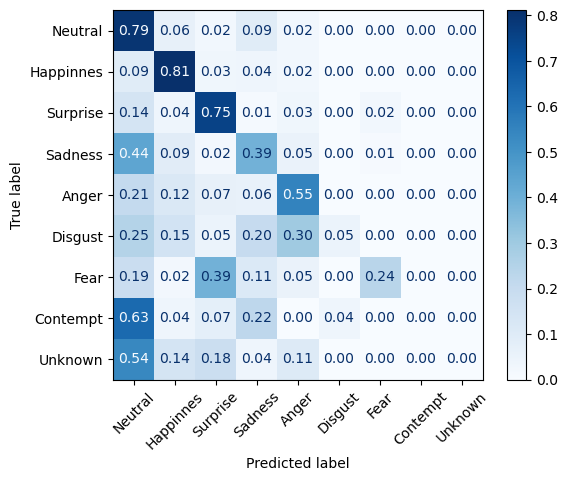

In [17]:
for i, params in enumerate(parameter_grid):
    learning_rate, batch_size, epochs, scheduler, optimizer, activation, criterion, device, dropout, augmentation = params 

    data_transforms= get_aug(aug=augmentation)
    train_dataset, valid_dataset, test_dataset = get_dataset(data_transforms=data_transforms)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Build the CNN model with the given parameters
    class Net(nn.Module):
        def __init__(self, drop=dropout):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        # output size = 6 *44*44 values 
        # image size : n*n 
        # filter size: f*f (f is odd number)
        # shrinked_image size : (n - f + 1)^2 

            self.bn1 = nn.BatchNorm2d(6)  # Batch normalization after conv1
            
            self.pool = nn.MaxPool2d(2, 2)
        # default stride is 2 because it was not specified so defaults to kernel size which is 2
        # output size = ((n-f+1)/2)^2 = 22*22 *6  
            
            self.conv2 = nn.Conv2d(6, 16, 5)
        #output size = 18 * 18 * 16 = 5184   
            
            self.bn2 = nn.BatchNorm2d(16)  # Batch normalization after conv2
            
            self.fc1 = nn.Linear(16 * 9 * 9, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
            
            self.dropout = nn.Dropout(p=drop)
            
        def forward(self, x):
            x = self.pool(activation(self.bn1(self.conv1(x)))) 
            # 44*44*6 , 22*22*6 
            
            x = self.pool(activation(self.bn2(self.conv2(x))))
            # 18*18*16 , 9*9*16 
            
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = activation(self.dropout(self.fc1(x)))
            x = activation(self.dropout(self.fc2(x)))
            x = self.fc3(x)
            return x

    torch.manual_seed(42)
    torch.mps.manual_seed(42) 
    model = Net()
    model.to(device)
    train_and_validate(epochs, optimizer, scheduler , criterion, model, trainloader, validloader, batch_size, learning_rate, activation, i+1, device, dropout, augmentation)
    # save model
    torch.save(model.state_dict(), f'{outputs_path}/models/trial_{i+1}.pth')
    plt.savefig(f"{outputs_path}/plots/accuracy-loss_{i+1}.png")
    plt.close()
    plt.close('all')


    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_model(model, testloader, i+1)
    
    # make sure there is no memory leaks 
    torch.mps.empty_cache()
    # clear ram
    del model
    # free memory
    import gc
    gc.collect()
    # free dataloader memory 
    del trainloader
    del validloader
    del testloader